In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = pd.read_csv('train.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


In [3]:
train_data = data.head(37800)
val_data = data.tail(4200)

train_labels = train_data.pop('label')
val_labels = val_data.pop('label')

In [4]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))

print(tf_train_data)
print(tf_val_data)

<_TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(784,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


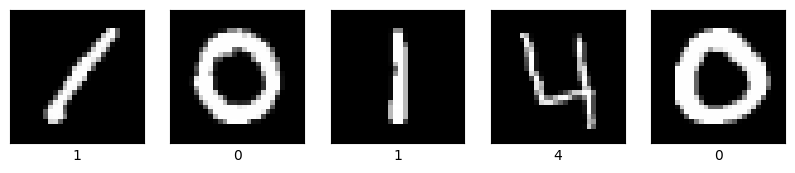

In [5]:
plt.figure(figsize=(10,10))
i = 0

for image, label in tf_train_data.take(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())

    i = i + 1

In [6]:
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32) / 255.

    return image, label

tf_train_data = tf_train_data.map(
    preprocess_image,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

tf_val_data = tf_val_data.map(
    preprocess_image,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

print(tf_train_data)
print(tf_val_data)

<_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_ParallelMapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [7]:
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100)
    tf_data = tf_data.batch(32)
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE)

    return tf_data

tf_train_data = pipeline(tf_train_data)
tf_val_data = pipeline(tf_val_data)

print(tf_train_data)
print(tf_val_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax'),
])

In [9]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimiser,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [10]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1),
]

In [11]:
train_log = model.fit(
    tf_train_data,
    validation_data=tf_val_data,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
1182/1182 [==============================] - 28s 22ms/step - loss: 0.2231 - accuracy: 0.9320 - val_loss: 0.0931 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 2/30
1182/1182 [==============================] - 25s 21ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.0847 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 3/30
1182/1182 [==============================] - 24s 20ms/step - loss: 0.0507 - accuracy: 0.9842 - val_loss: 0.0548 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 4/30
1182/1182 [==============================] - 27s 23ms/step - loss: 0.0384 - accuracy: 0.9879 - val_loss: 0.0533 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 5/30
1182/1182 [==============================] - 23s 20ms/step - loss: 0.0286 - accuracy: 0.9913 - val_loss: 0.0510 - val_accuracy: 0.9821 - lr: 0.0010
Epoch 6/30
1182/1182 [==============================] - 26s 22ms/step - loss: 0.0247 - accuracy: 0.9922 - val_loss: 0.0582 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 7/30
1182/1182 [========================

Training accuracy: 1.000000
Validation accuracy: 0.989762


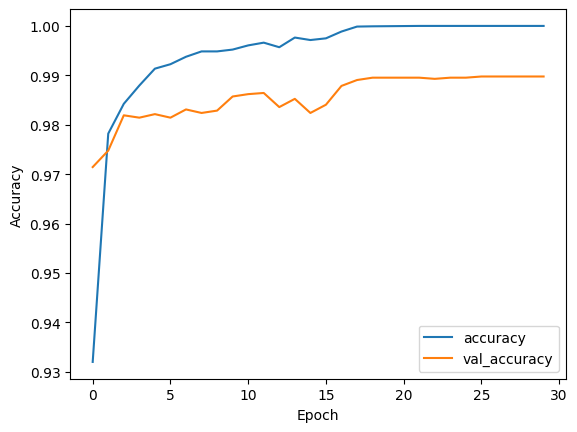

In [12]:
plt.plot(train_log.history['accuracy'], label='accuracy')
plt.plot(train_log.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % train_log.history['accuracy'][-1])
print('Validation accuracy: %f' % train_log.history['val_accuracy'][-1])

In [13]:
test_data = pd.read_csv('test.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

In [14]:
predictions = model.predict(tf_test_data)
predictions = np.argmax(predictions, axis=1)

1/1 [==============================] - 6s 6s/step


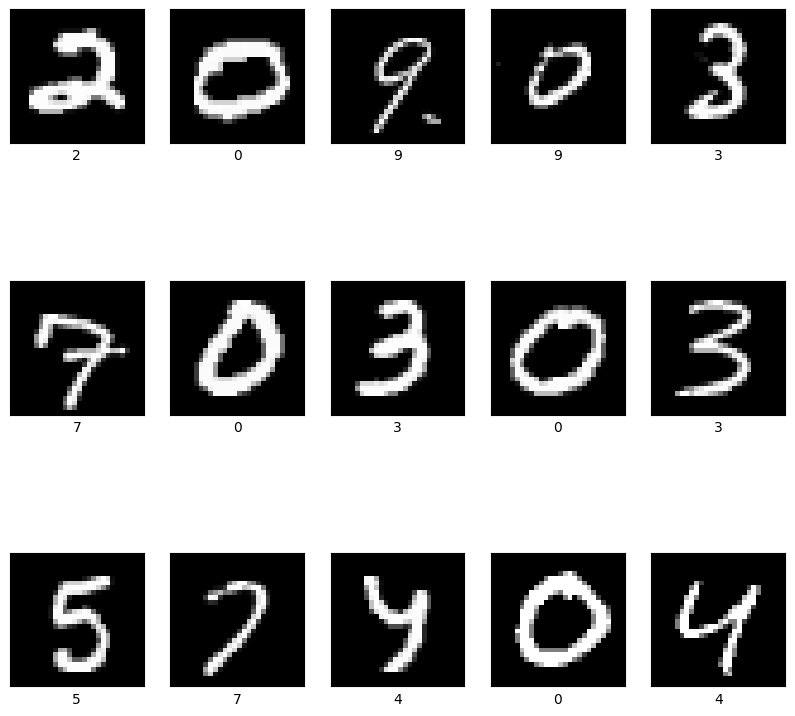

In [15]:
plt.figure(figsize=(10,10))

for i, row in test_data.head(15).iterrows():
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])

In [16]:
predictions_df = pd.DataFrame(data={'Label': predictions}, index=pd.RangeIndex(start=1, stop=28001))
predictions_df.index = predictions_df.index.rename('ImageId')

predictions_df.to_csv('submission_file.csv')